In [20]:
# 导入相关库
import numpy as np
from scipy.io import loadmat
import scipy.stats
import matplotlib.pyplot as plt

# 归一化数据
def autos(X):
    m = X.shape[0]
    n = X.shape[1]
    X_m = np.zeros((m, n))
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    for i in range(n):
        a = np.ones(m) * mu[i]
        X_m[:, i] = (X[:, i]-a) / sigma[i]
    return X_m, mu, sigma

def autos_test(data,m_train,v_train):
    m = data.shape[0]
    n = data.shape[1]
    data_new = np.zeros((m, n))
    for i in range(n):
        a = np.ones(m) * m_train[i]
        data_new[:, i] = (data[:, i] - a) / v_train[i]
    return data_new

def pls_nipals(X, Y, A, max_iter=2000, epsilon=1e-10):
    olv=A
    rankx=np.linalg.matrix_rank(X)
    if olv>=rankx:
        A=rankx
        
    ssqx=np.sum(X**2)
    ssqy=np.sum(Y**2)
    ssq=np.zeros((A,2))
    ssqdiff=np.zeros((A,2))
    t_old = 0
    iters = 0 
    u = Y[:,0].reshape(Y.shape[0],1)
    while iters < max_iter:
        W = X.T @ u / (np.linalg.norm(X.T @ u))
        W = W/np.linalg.norm(W)
        T = X @ W
        Q = Y.T @ T / (T.T @ T)
        Q=Q/np.linalg.norm(Q)
        u = Y @ Q
        t_diff = T - t_old
        t_old = T
        if np.linalg.norm(t_diff) < epsilon:
            P = X.T @ T / (T.T @ T)
            X = X - T @ (P.T)
            B=u.T@T/(T.T@T)
            Y=Y-B[0,0]*T@Q.T
            break
        else:
            iters += 1
            
    ssq[0,0] = np.sum(X**2)*100/ssqx;
    ssq[0,1] = np.sum(Y**2)*100/ssqy;
    
    for i in range(1,A):
        t_old = 0
        iters = 0
        u = Y[:,0].reshape(Y.shape[0],1)
        while iters < max_iter:
            w = X.T @ u / (np.linalg.norm(X.T @ u))
            w = w/np.linalg.norm(w)
            t = X @ w
            q = Y.T @ t / (t.T @ t)
            q=q/np.linalg.norm(q)
            u = Y @ q
            t_diff = t - t_old
            t_old = t
            if np.linalg.norm(t_diff) < epsilon:
                p = X.T @ t / (t.T @ t)
                p=p/np.linalg.norm(p)
                X = X - t @ (p.T)
                b=u.T@t/(t.T@t)
                Y=Y-b[0,0]*t@q.T
                t_old = t
                T = np.hstack((T,t))               
                W = np.hstack((W,w))
                Q = np.hstack((Q,q))
                P = np.hstack((P,p))
                B = np.hstack((B,b))
                break
            else:
                iters += 1    
        ssq[i,0] = np.sum(X**2)*100/ssqx;
        ssq[i,1] = np.sum(Y**2)*100/ssqy;

    ssqdiff[0,0] = 100 - ssq[0,0];
    ssqdiff[0,1] = 100 - ssq[0,1];
    ssqdiff[1:,:]=ssq[0:-1,:]-ssq[1:,:]
    R = W @ np.linalg.inv((P.T @ W))
    return T,W,Q,P,R,B,ssqdiff,ssq


###  读取数据及数据预处理
以TE过程的数据为例

In [22]:
path_train = 'E:\myFile\Tencent Files\故障诊断代码及接口\d00.mat'
path_test= 'E:\myFile\Tencent Files\故障诊断代码及接口\d01te.mat'
data1 = loadmat(path_train)['d00']
X1 = data1[:,:22]
X2 = data1[:,-11:]
X_Train= np.hstack((X1,X2))
Y_Train = data1[:,34:35]

data2 = loadmat(path_test)['d01te']
X11 = data2[:,:22]
X22 = data2[:,-11:]
X_test = np.hstack((X11,X22))
# Y_test  = data2[:,34:36]
Y_test  = data2[:,34:35]

# 数据标准化
##训练数据标准化
X_train,X_mean,X_s = autos(X_Train)
Y_train,Y_mean,Y_s = autos(Y_Train)
##测试数据标准化
X_test = autos_test(X_test,X_mean,X_s)
Y_test = autos_test(Y_test,Y_mean,Y_s)

### pls建模

In [23]:
A = 6#pls主元数
T, W, Q, P, R, B, ssqdiff, ssq = pls_nipals(X_train, Y_train, A)

In [24]:
# T
# T2_lim
R

array([[ 0.0066054 ,  0.0239479 ,  0.09915513,  0.19686223, -0.05804812,
        -0.04546579],
       [ 0.0029566 ,  0.13784901, -0.0359289 ,  0.0627998 ,  0.21558676,
        -0.10231571],
       [-0.11062335, -0.06644532,  0.06209414,  0.17109401,  0.11282844,
         0.01196746],
       [-0.0302707 ,  0.05705448,  0.37558713,  0.38915506,  0.35091424,
        -0.09809502],
       [-0.01025069,  0.01705137, -0.03371747, -0.06523191,  0.02115081,
         0.10931211],
       [-0.12985395, -0.50998158, -0.4577494 , -0.02855072,  0.08401848,
         0.06150715],
       [-0.424478  , -0.13380956, -0.12036163, -0.29135874, -0.29253259,
        -0.25779472],
       [-0.1151989 , -0.27842192, -0.16813501,  0.05696534,  0.10697324,
         0.10105778],
       [-0.03310534,  0.02724157, -0.41114618, -0.42240855, -0.20233514,
        -0.20645556],
       [ 0.20550283,  0.00750479, -0.10468828, -0.36083903, -0.16749936,
        -0.08956421],
       [ 0.20409901, -0.05734961, -0.20326096, -0.

### 确定控制限

In [6]:
alpha=0.95;# 显著性水平
X_hat = X_train-X_train@R@P.T
n = X_train.shape[0]
T2_lim = A*(n** 2-1)/(n*(n-A)) * scipy.stats.f.ppf(alpha, A, n-A) # T2控制限 

Qx_normal=[]
for i in range(X_hat.shape[0]):
    Qx_normal.append(X_hat[i,:].T @ X_hat[i,:])
S1=np.var(Qx_normal); 
mio1=np.mean(Qx_normal);
V1=2*mio1**2/S1; 
Q_lim=S1/(2*mio1)*scipy.stats.chi2.ppf(alpha,V1);

### 计算测试数据的监控结果

In [17]:
T_value = []
Q_value = []
for i in range(X_test.shape[0]):
    t = R.T @ X_test[i,:]
    xr_old = X_test[i,:].T-P@R.T@X_test[i,:].T
    T_value.append(t.T @ np.linalg.inv((T.T @ T) / (X_train.shape[0] - 1)) @ t)
#     T_value.append(t.T @ t)
    Q_value.append(xr_old.T@xr_old)

In [25]:
X_test[0]

array([-3.10920773e-02, -1.97860947e-01,  2.70541214e-01,  6.82150723e-01,
       -9.23906709e-01, -6.68428769e-01, -1.70498649e-01, -7.41611651e-01,
        1.10215961e+00, -4.98164839e-02, -2.15937157e-01, -1.72392861e+00,
       -3.02536349e-01, -1.37115422e+00,  1.04267320e+00, -2.61287867e-04,
        1.23914031e-01,  9.72598449e-03, -1.25439566e-02,  1.14882532e-01,
       -4.89137531e-01, -9.56739073e-01,  2.50598909e-01, -3.63969433e-01,
       -1.81465040e-02,  4.35857385e-01, -3.65623197e-01, -2.65641496e-03,
       -1.72404934e+00,  1.04281205e+00, -1.01458237e-03,  1.41992067e+00,
       -1.12147713e-01])

In [10]:
T_value

[2.8031489658085103]

In [11]:
(X_train.shape[0] - 1)

499

### 对测试数据的监控结果可视化

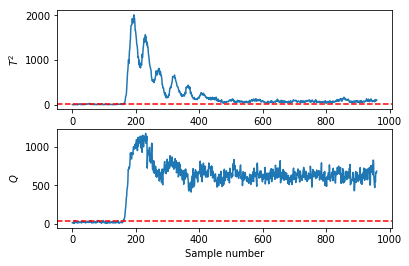

In [18]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(T_value)
plt.xlabel('Sample number')
plt.ylabel('$T^2$')
plt.axhline(y=T2_lim,ls="--",color="r")
plt.subplot(2,1,2)
plt.plot(Q_value)
plt.xlabel('Sample number')
plt.ylabel('$Q$')
plt.axhline(y=Q_lim,ls="--",color="r")
plt.show()

### pls预测结果可视化

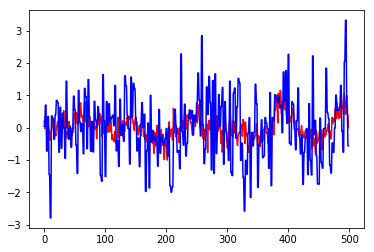

In [13]:
T_pred = X_train @ R;
Y_pred = T_pred @ np.diag(B[0])@ Q.T;

plt.figure()
plt.plot(Y_pred,color="r")
plt.plot(Y_train,color="b")
plt.show()

In [14]:
T_value

[2.8031489658085103]